In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
# import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict
from tqdm import tqdm

import polars as pl

In [2]:
from monk import utils, workflow

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
# get d2min distribution

# rev_quant = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"
        
        if float(period) != 1000:
            continue

        # if job.isfile(out_path):
        #     continue

        print(sp)

        traj = gsd.hoomd.open(exper)

        frame_is = []
        frame_js = []
        ids = []
        msds = []
        ave_msds = []
        comp_start = lambda i: -1 + i*40
        for i in tqdm(range(1, 200, 50)):
            snap = traj[-1 + i*40]
            tags = np.arange(len(snap.particles.position))

            init_pos = snap.particles.position
            images = np.zeros_like(init_pos, dtype=np.int32)
            last_pos = init_pos.copy()
            freud_box = freud.box.Box.from_box(snap.configuration.box)
            center = init_pos.mean(axis=0)

            for j in range(i + 1, 200):
                
                frame_is.append(-1 + i*40)
                frame_js.append(-1 + j*40)

                snap_later = traj[-1 + j*40]

                box = snap.configuration.box[:]
                box_later = snap_later.configuration.box[:]
                ids.append(tags)

                # compute msd
                pos = snap_later.particles.position
                images -=  freud_box.get_images(pos - last_pos)
                last_pos = pos
                new_pos = freud_box.unwrap(pos, images)
                new_pos -= new_pos.mean(axis=0)
                msd = np.sum(np.square(new_pos - init_pos + center), axis=-1)
                ave_msds.append(np.mean(msd))
                msds.append(msd)
        
        dataset = pl.DataFrame({"frame_i": frame_is, "frame_j": frame_js, "id": ids, "msd": msds, "ave_msd": ave_msds})
        dataset.write_parquet(job.fn(out_path), use_pyarrow=True)
        msds = np.array(msds)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.01, period=1000.0, temp=0.14877, prep='HTL')


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Statepoint(max_shear=0.02, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Statepoint(max_shear=0.02, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Statepoint(max_shear=0.03, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Statepoint(max_shear=0.03, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Statepoint(max_shear=0.04, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Statepoint(max_shear=0.04, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Statepoint(max_shear=0.05, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Statepoint(max_shear=0.05, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Statepoint(max_shear=0.06, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Statepoint(max_shear=0.06, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Statepoint(max_shear=0.06, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Statepoint(max_shear=0.06, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Statepoint(max_shear=0.06, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Statepoint(max_shear=0.07, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Statepoint(max_shear=0.08, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Statepoint(max_shear=0.08, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.14877, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.19836, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.049591, prep='HTL')


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.099182, prep='HTL')


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


7ec2f6aca035e69077eab24383a21cb6
Statepoint(max_shear=0.01, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Statepoint(max_shear=0.01, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Statepoint(max_shear=0.02, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Statepoint(max_shear=0.02, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Statepoint(max_shear=0.03, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Statepoint(max_shear=0.04, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Statepoint(max_shear=0.04, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Statepoint(max_shear=0.05, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Statepoint(max_shear=0.06, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Statepoint(max_shear=0.06, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Statepoint(max_shear=0.06, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


Statepoint(max_shear=0.06, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Statepoint(max_shear=0.06, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Statepoint(max_shear=0.07, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Statepoint(max_shear=0.08, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.14877, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.19836, prep='ESL')


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.049591, prep='ESL')


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Statepoint(max_shear=0.12, period=1000.0, temp=0.099182, prep='ESL')


100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [6]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path))
            output[sp].append(dataset)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


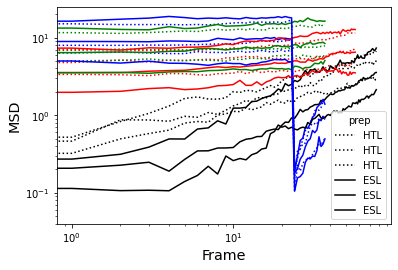

In [7]:
for key, data in output.items():
    pair = key.prep
    # print(key)
    if key.temp < 5e-2 or key.max_shear != 0.05:
        continue
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tw1 = []
    tw2 = []
    tw3 = []
    tw4 = []
    for d in data:
        tw1.append(d[:78]["ave_msd"].to_numpy())
        tw2.append(d[78: 78+79-21]["ave_msd"].to_numpy())
        tw3.append(d[136: 136+79-41]["ave_msd"].to_numpy())
        tw4.append(d[174: 174+79-41]["ave_msd"].to_numpy())
    tw1 = np.mean(tw1, axis=0)
    tw2 = np.mean(tw2, axis=0)
    tw3 = np.mean(tw3, axis=0)
    tw4 = np.mean(tw4, axis=0)
    plt.plot(tw1, label=f"{pair}", ls=ls, color="black")
    plt.plot(tw2, ls=ls, color="red")
    plt.plot(tw3, ls=ls, color="green")
    plt.plot(tw4, ls=ls, color="blue")
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
plt.yscale('log')
plt.xscale('log')
plt.legend(title="prep")
# plt.ylim(0, 0.05)

In [110]:
htl_dataset = dataset

In [108]:
esl_dataset = dataset

In [102]:
dataset.head()

frame_i,frame_j,id,msd,ave_msd
i64,i64,list[i64],list[f32],f32
39,79,"[0, 1, … 32767]","[0.176803, 0.348364, … 0.164253]",0.368779
39,119,"[0, 1, … 32767]","[0.830507, 2.919159, … 0.850515]",0.660435
39,159,"[0, 1, … 32767]","[1.460129, 3.245783, … 4.204572]",1.035998
39,199,"[0, 1, … 32767]","[1.767935, 4.78026, … 2.064315]",1.066434
39,239,"[0, 1, … 32767]","[0.419333, 11.014839, … 1.018142]",1.421013


In [82]:
msds.shape

(192, 32768)

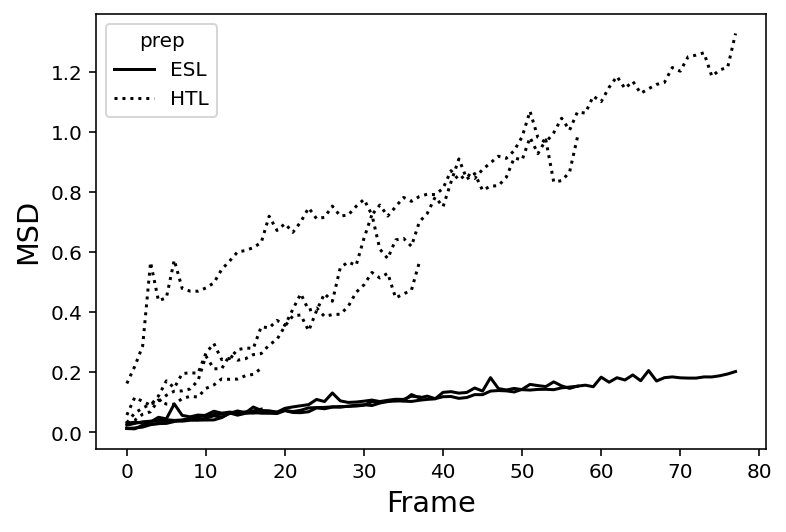

In [135]:
# cmap = cm.viridis
plt.plot(esl_dataset[:78]["ave_msd"].to_numpy(), color="k", label="ESL")
plt.plot(esl_dataset[78: 78+79-21]["ave_msd"].to_numpy(), color="k")
plt.plot(esl_dataset[136: 136+79-41]["ave_msd"].to_numpy(), color="k")
plt.plot(esl_dataset[174: 174+79-41]["ave_msd"].to_numpy(), color="k")
plt.plot(htl_dataset[:78]["ave_msd"].to_numpy(), color="k", linestyle=":", label="HTL")
plt.plot(htl_dataset[78: 78+79-21]["ave_msd"].to_numpy(), color="k", linestyle=":")
plt.plot(htl_dataset[136: 136+79-41]["ave_msd"].to_numpy(), color="k", linestyle=":")
plt.plot(htl_dataset[174: 174+79-41]["ave_msd"].to_numpy(), color="k", linestyle=":")
# plt.ylim(0, 2)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
plt.legend(title="prep")

In [11]:
5e-2

0.05

In [16]:
data

[shape: (492, 5)
 ┌─────────┬─────────┬─────────────────┬──────────────────────────────────┬──────────┐
 │ frame_i ┆ frame_j ┆ id              ┆ msd                              ┆ ave_msd  │
 │ ---     ┆ ---     ┆ ---             ┆ ---                              ┆ ---      │
 │ i64     ┆ i64     ┆ list[i64]       ┆ list[f32]                        ┆ f32      │
 ╞═════════╪═════════╪═════════════════╪══════════════════════════════════╪══════════╡
 │ 39      ┆ 79      ┆ [0, 1, … 32767] ┆ [0.01458, 0.019803, … 0.010769]  ┆ 0.08482  │
 │ 39      ┆ 119     ┆ [0, 1, … 32767] ┆ [0.049492, 0.042714, … 0.00936]  ┆ 0.104236 │
 │ 39      ┆ 159     ┆ [0, 1, … 32767] ┆ [0.02969, 0.005812, … 0.004621]  ┆ 0.14051  │
 │ 39      ┆ 199     ┆ [0, 1, … 32767] ┆ [0.09698, 0.153687, … 0.049847]  ┆ 0.154553 │
 │ …       ┆ …       ┆ …               ┆ …                                ┆ …        │
 │ 6039    ┆ 7839    ┆ [0, 1, … 32767] ┆ [0.028684, 0.0819, … 0.021]      ┆ 0.008371 │
 │ 6039    ┆ 7879    ┆ [0,

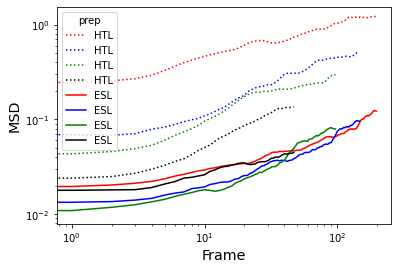

In [64]:
from scipy.ndimage import uniform_filter1d

temps = [0.019836, 0.049591, 0.099182, 0.14877, 0.19836]

for key, data in output.items():
    pair = key.prep
    # print(key)
    if key.temp != temps[1] or key.max_shear != 0.04:
        continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tws = [[], [], [], []]
    colors = ["r", "b", "g", "k"]
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    for tw, c in zip(tws, colors):
        plt.plot(uniform_filter1d(tw, 10), label=f"{pair}", ls=ls, color=c)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
plt.yscale('log')
plt.xscale('log')
plt.legend(title="prep")
# plt.ylim(0, 0.05)

In [25]:
type(d)

polars.dataframe.frame.DataFrame

In [101]:
esl_dataset["msd_ave"]

ColumnNotFoundError: msd_ave

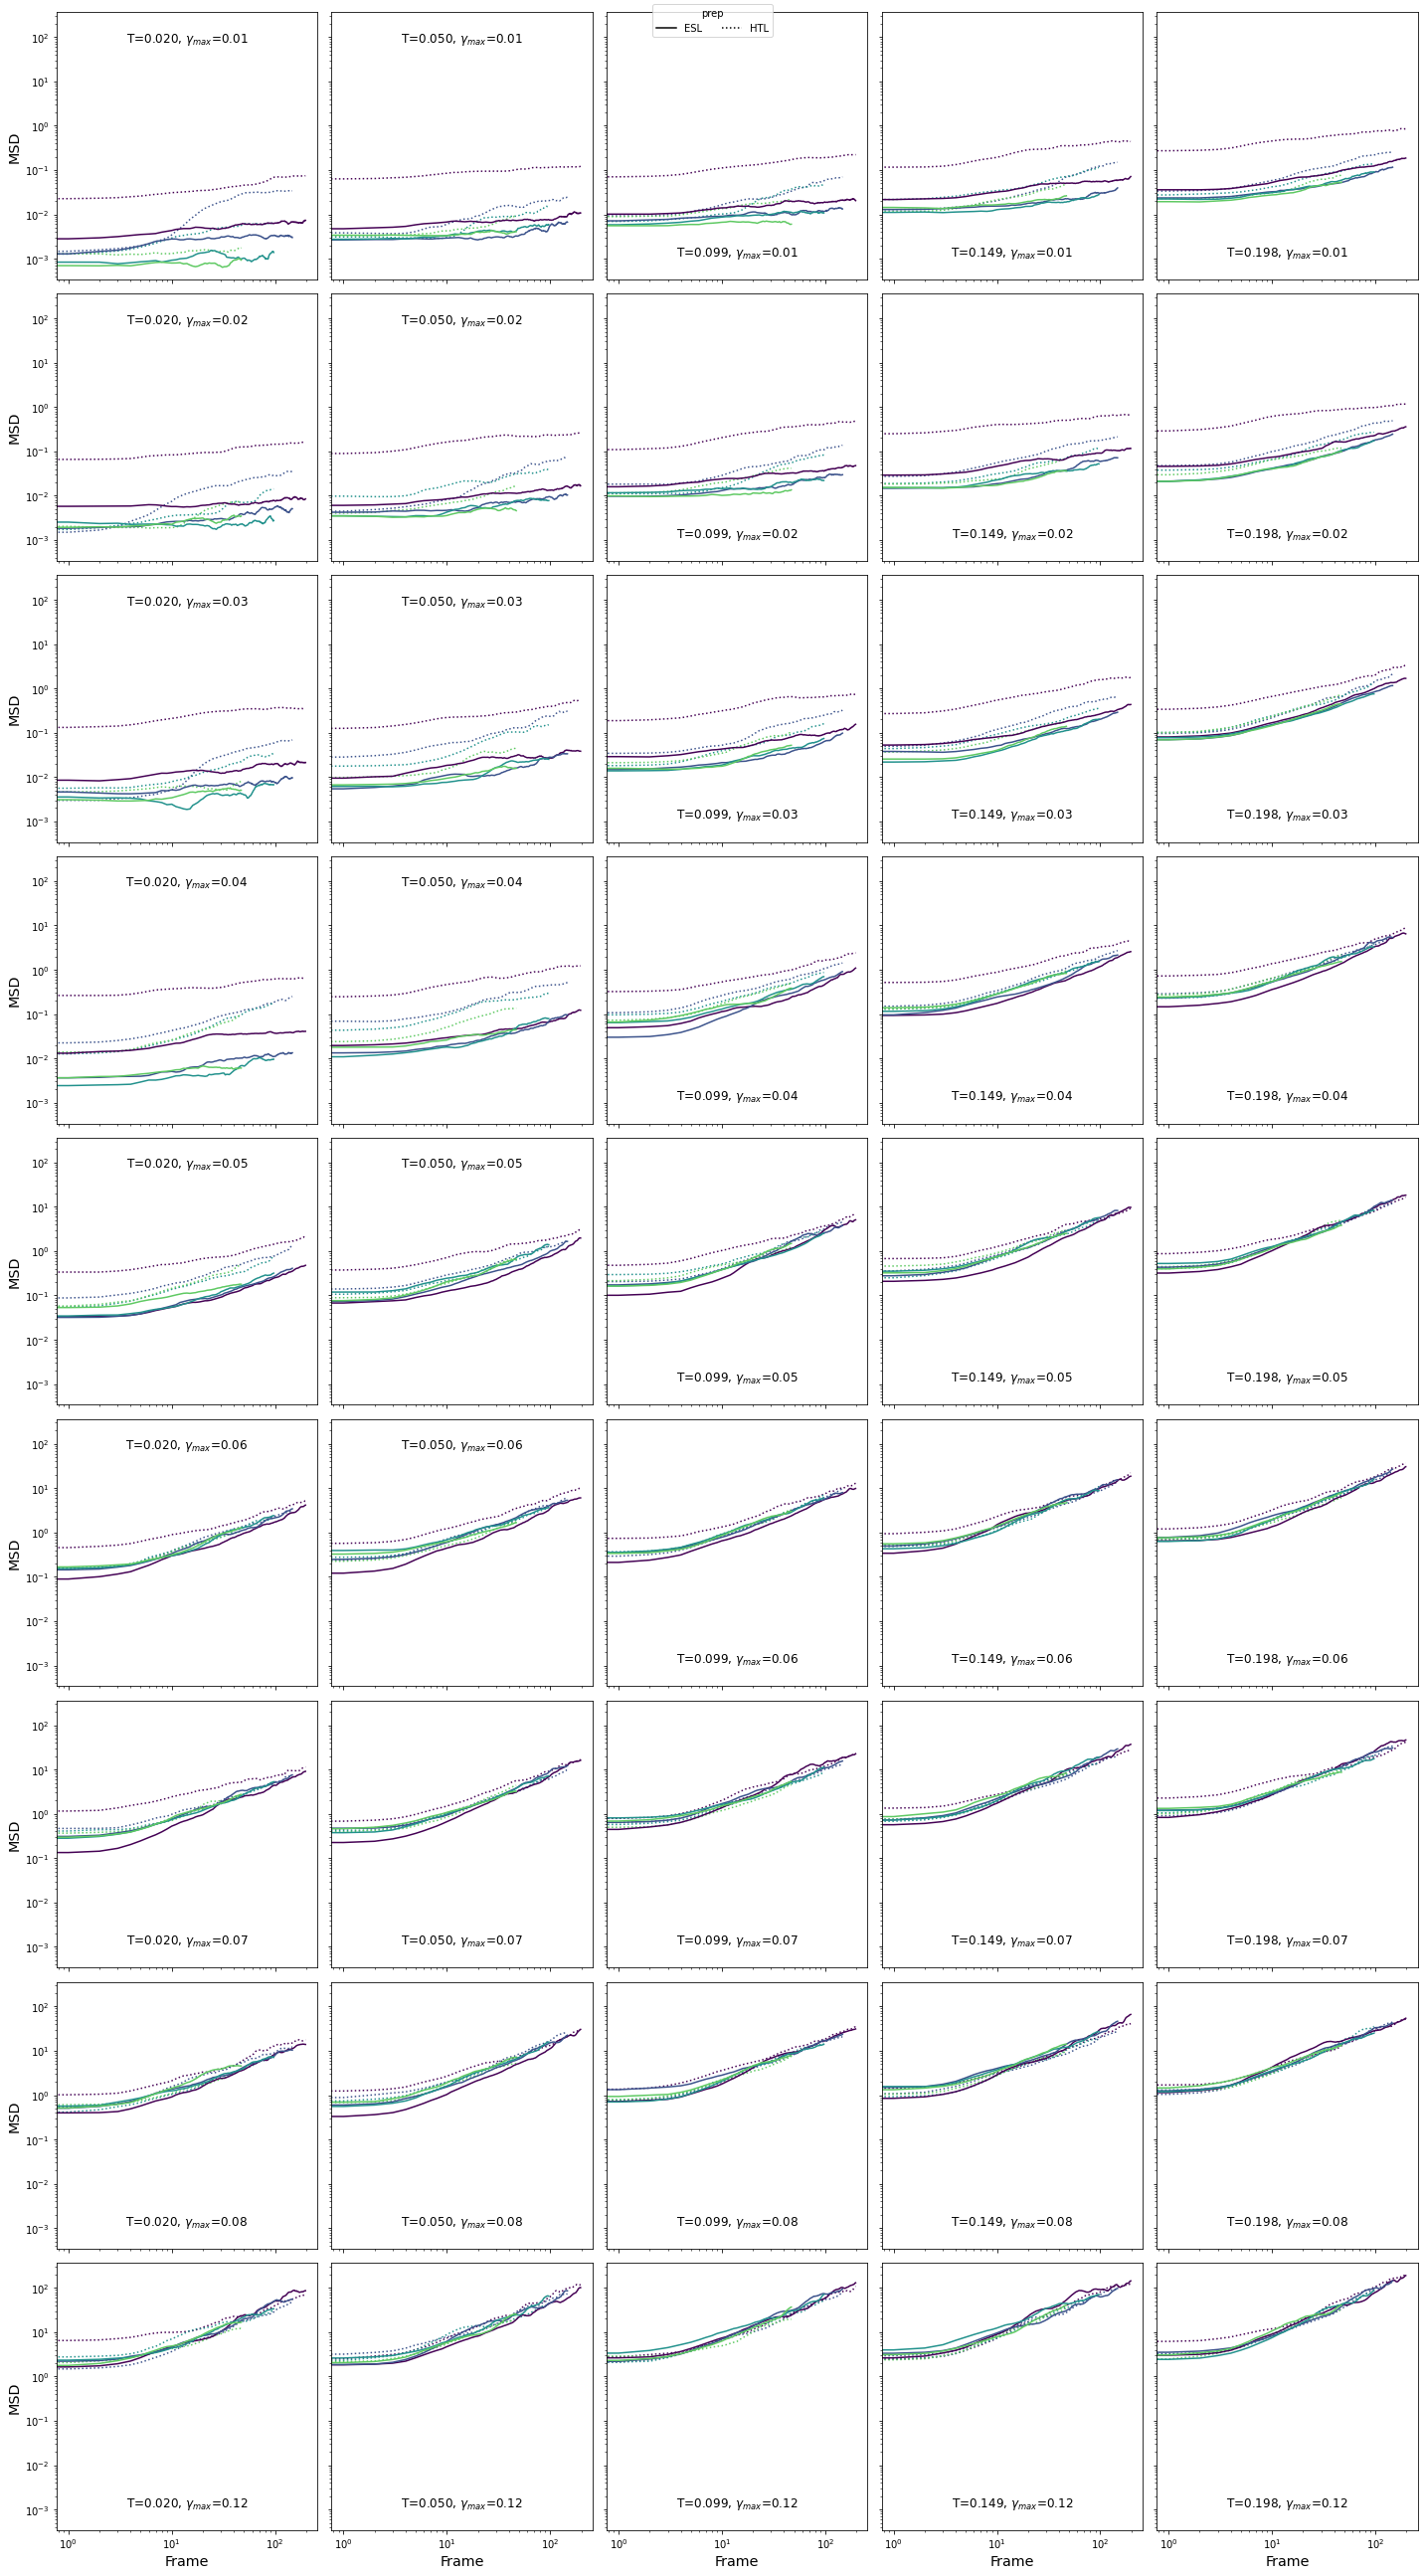

In [79]:
from scipy.ndimage import uniform_filter1d

temps = [0.019836, 0.049591, 0.099182, 0.14877, 0.19836]
shears = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.12]

cmap = cm.viridis

fig, axs = plt.subplots(9, 5, figsize=(20, 36), sharex=True, sharey=True)

colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    # if key.temp != temps[1] or key.max_shear != 0.04:
    #     continue
    # print(key.temp)
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tws = [[], [], [], []]
    i = temps.index(key.temp)
    j = shears.index(key.max_shear)
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    for tw, c in zip(tws, colors):
        axs[j, i].plot(uniform_filter1d(tw, 10), label=f"{pair}", ls=ls, color=c)
# plt.ylabel("MSD", size="x-large")
# plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title="prep")
# plt.ylim(0, 0.05)
for ax in axs.ravel():
    ax.set_yscale('log')
    ax.set_xscale('log')

for ax in axs[-1, :]:
    ax.set_xlabel("Frame", size="x-large")

for ax in axs[:, 0]:
    ax.set_ylabel("MSD", size="x-large")

for i in range(5):
    for j in range(9):
        if i < 2 and j < 6:
            pos = (0.5, 0.9)
        else:
            pos = (0.5, 0.1)
        axs[j, i].text(*pos, fr"T={temps[i]:.3f}, $\gamma_{{max}}$={shears[j]}", transform=axs[j, i].transAxes, ha="center", va="center", size="large")

handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="-", label="ESL"), mpl.lines.Line2D([0], [0], color="k", linestyle=":", label="HTL")]

fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

plt.tight_layout()

plt.savefig("big-msd.png", dpi=300)

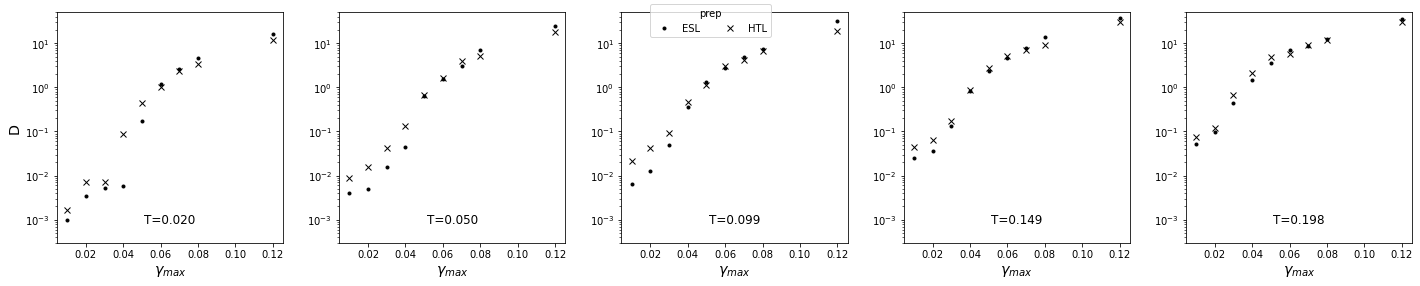

In [95]:
from scipy.ndimage import uniform_filter1d

temps = [0.019836, 0.049591, 0.099182, 0.14877, 0.19836]
shears = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.12]

cmap = cm.viridis

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True)

colors = [cmap(0), cmap(0.25), cmap(0.5), cmap(0.75)]

for key, data in output.items():
    pair = key.prep
    # print(key)
    # if key.temp != temps[1] or key.max_shear != 0.04:
    #     continue
    # print(key.temp)
    if pair == "ESL":
        ls = "."
    else:
        ls = "x"
    tws = [[], [], [], []]
    i = temps.index(key.temp)
    j = shears.index(key.max_shear)
    for d in data:
        for idx, (_, di) in enumerate(d.group_by("frame_i", maintain_order=True)):
            # print(idx)
            tws[idx].append(di[:]["ave_msd"].to_numpy())
            # break
    tws = [np.mean(tw, axis=0) for tw in tws]
    # for tw, c in zip(tws, colors):
    # axs[j, i].plot(uniform_filter1d(tw, 10), label=f"{pair}", ls=ls, color=c)
    axs[i].plot(key.max_shear, uniform_filter1d(tws[-1], 20)[-1], ls, label=f"{pair}", color="k")
# plt.ylabel("MSD", size="x-large")
# plt.xlabel("Frame", size="x-large")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(title="prep")
# plt.ylim(0, 0.05)
for ax in axs.ravel():
    ax.set_yscale('log')
    # ax.set_xscale('log')

# for ax in axs[-1, :]:
#     ax.set_xlabel("Frame", size="x-large")

# for ax in axs[:, 0]:
#     ax.set_ylabel("MSD", size="x-large")

for i in range(5):
    pos = (0.5, 0.1)
    axs[i].text(*pos, f"T={temps[i]:.3f}", transform=axs[i].transAxes, ha="center", va="center", size="large")

# handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="-", label="ESL"), mpl.lines.Line2D([0], [0], color="k", linestyle=":", label="HTL")]

# fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

# plt.tight_layout()

# plt.savefig("big-msd.png", dpi=300)
axs[0].set_ylabel("D", size="x-large")
for ax in axs:
    ax.set_xlabel(r"$\gamma_{max}$", size="x-large")
    ax.set_ylim(3e-4, 5e1)

handles = [mpl.lines.Line2D([0], [0], color="k", linestyle="", marker=".", label="ESL"), mpl.lines.Line2D([0], [0], color="k", marker="x", linestyle="", label="HTL")]

fig.legend(handles=handles, title="prep", loc='upper center', ncol=2)

plt.tight_layout()

plt.savefig("diffusion.png", dpi=300)